In [1]:
# Load Dependancies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind


In [2]:
# Read in the larger, already compiled Full Moon Phase data
moon_data = "../Resources/Moon_Data_Full_Other.csv" 

# Reading in the Moon data (full moon phase vs. Other)
moon_df = pd.read_csv(moon_data)

# Convert the Date column to "datetime"
moon_df['Date'] = pd.to_datetime(moon_df['Date'])

# Drop the Universal time column
moon_df.drop(columns=['Time (Universal Time)'], inplace=True)

# Display the data
moon_df.info()
display(moon_df.tail(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Moon Phase  537 non-null    object        
 1   Date        537 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 8.5+ KB


,Moon Phase,Date
536,Other,2015-01-13


In [6]:
# Read in the Los Angles CA Crime data
la_crime = "../Resources/LA_Crime.csv" 

# Reading in the Los Angles Crime data
la_crime_df = pd.read_csv(la_crime)

la_crime_df.info()
display(la_crime_df.tail(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004681 entries, 0 to 1004680
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   Date     1004681 non-null  object
 1   Offense  1004681 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


,Date,Offense
1004680,2024-08-12 00:00:00+00:00,VEHICLE - STOLEN


In [8]:
# Convert the LA Crime Date column to "datetime"
la_crime_df['Date'] = pd.to_datetime(la_crime_df['Date'])   

# Display the Austin Crime data
la_crime_df.info()
display(la_crime_df.tail(1)) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004681 entries, 0 to 1004680
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype              
---  ------   --------------    -----              
 0   Date     1004681 non-null  datetime64[ns, UTC]
 1   Offense  1004681 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 15.3+ MB


,Date,Offense
1004680,2024-08-12 00:00:00+00:00,VEHICLE - STOLEN


In [12]:
# Localize (Convert) the LA Crime UTC 'Date' column
la_crime_df['Date'] = la_crime_df['Date'].dt.tz_localize(None) 

# Merge the two Datasets (Moon Phases and Austin Crime)
merged_df = pd.merge(la_crime_df, moon_df, left_on='Date', right_on='Date', how='inner')
# Display the merged data
merged_df.info()
display(merged_df.tail(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134403 entries, 0 to 134402
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        134403 non-null  datetime64[ns]
 1   Offense     134403 non-null  object        
 2   Moon Phase  134403 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 3.1+ MB


,Date,Offense,Moon Phase
134400,2024-01-25,BURGLARY FROM VEHICLE,Full Moon
134401,2024-10-02,VEHICLE - STOLEN,Other
134402,2024-08-12,VEHICLE - STOLEN,Other


In [14]:
# Export to CSV
merged_df.to_csv('merged_la_moon_df.csv', index=False, header=True)

In [16]:
# Inspect the data
def inspect_data(merged_df):
    # Count moon phases
    moon_phase_counts = merged_df['Moon Phase'].value_counts()
    print(f"moon_phase_counts:\n{moon_phase_counts}\n")
    # Count highest offense codes
    offense_code_counts = merged_df['Offense'].value_counts()
    print(f"offense_code_counts:\n{offense_code_counts}\n")
    # Count the number of unique dates]
    unique_dates = merged_df['Date'].nunique()
    print(f"Number of unique dates: {unique_dates}\n")
    # Count the number of unique offense codes
    unique_offense_codes = merged_df['Offense'].nunique()
    print(f"Number of unique offense codes: {unique_offense_codes}\n")
    # Count the number of unique moon phases
    unique_moon_phases = merged_df['Moon Phase'].nunique()
    print(f"Number of unique moon phases: {unique_moon_phases}\n")
inspect_data(merged_df)
    


moon_phase_counts:
Moon Phase
Other        100082
Full Moon     34321
Name: count, dtype: int64

offense_code_counts:
Offense
VEHICLE - STOLEN                                           15037
BATTERY - SIMPLE ASSAULT                                   10145
BURGLARY FROM VEHICLE                                       8303
BURGLARY                                                    8224
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     8103
                                                           ...  
TILL TAP - GRAND THEFT ($950.01 & OVER)                        1
BLOCKING DOOR INDUCTION CENTER                                 1
GRAND THEFT / AUTO REPAIR                                      1
BRIBERY                                                        1
THEFT, COIN MACHINE - GRAND ($950.01 & OVER)                   1
Name: count, Length: 130, dtype: int64

Number of unique dates: 236

Number of unique offense codes: 130

Number of unique moon phases: 2



In [18]:
# Use SCIPY to look for Stistically relevant relationships between Moon data and Crime in Austin
contingency_table = pd.crosstab(merged_df['Moon Phase'], merged_df['Offense'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-Square Value: {chi2:.2f}')
print(f'p-Value: {p:.2f}')
print(f'Degrees of Freedom (DOF): {dof}')
# OBSERVATION: 
print(f'OBSERVATION: Significant Relationship: {"Yes" if p < 0.05 else f"None found, as the p-value {p:.2f} is much larger than 0.05 (the typical significance threshold).\n Additionally, the chi-square value of 107.78 with 113 degrees of freedom confirms this, telling us the crime occurances compared to \n Full Moon phases are distributed fairly randomly."}')

Chi-Square Value: 257.28
p-Value: 0.00
Degrees of Freedom (DOF): 129
OBSERVATION: Significant Relationship: Yes


In [27]:
# Group Moon Phases and Crime Incidents and compare counts
grouped = merged_df.groupby(['Moon Phase', pd.Grouper(key='Date', freq='D')]).size().reset_index(name='crime_count')

# Calculate Average Crimen by Moon Phase:
ave_crimes_by_phase = grouped.groupby('Moon Phase')['crime_count'].agg(['mean', 'std','count'])
ave_crimes_by_phase = ave_crimes_by_phase.round(2)
print(ave_crimes_by_phase)
# OBSERVATIONS: 
print('The crime rate difference of 3.8% Between Full Moon (553.56) and other phases (575.18) tells us the crime rate is on average slightly\n '
'higher during non-Full Moon phases. The Standard deviation is higher for Full Moon days (165.21, vs 158.16) and this may warrant further investigation on the increased variance of crimes.')

              mean     std  count
Moon Phase                       
Full Moon   553.56  165.21     62
Other       575.18  158.16    174
The crime rate difference of 3.8% Between Full Moon (553.56) and other phases (575.18) tells us the crime rate is on average slightly
 higher during non-Full Moon phases. The Standard deviation is higher for Full Moon days (165.21, vs 158.16) and this may warrant further investigation on the increased variance of crimes.


In [30]:
# Appy a 't-test' to verify if statistically significant:
full_moon_counts = grouped[grouped['Moon Phase']  == 'Full Moon']['crime_count']
other_phase_counts = grouped[grouped['Moon Phase']  == 'Other']['crime_count']

t_stat, p_val = ttest_ind(full_moon_counts, other_phase_counts, equal_var=False)
print(f't-Statistic: {t_stat:.2f}, \np-value: {p_val:.2f}')
# OBSERVATIONS:
print(f'The t-value {t_stat:.2f} is negative and indicates there is no significant statistical difference between Full Moon and other Moon Phases.')
print(f'The p-value of {p_val:.2f} is well over the 0.05 threshold, and therefore indicates random chance will account for crimes moreso than Full Moon or Other Moon Phases.')

t-Statistic: -0.89, 
p-value: 0.37
The t-value -0.89 is negative and indicates there is no significant statistical difference between Full Moon and other Moon Phases.
The p-value of 0.37 is well over the 0.05 threshold, and therefore indicates random chance will account for crimes moreso than Full Moon or Other Moon Phases.


23:26:52 - cmdstanpy - INFO - Chain [1] start processing
23:26:52 - cmdstanpy - INFO - Chain [1] done processing


<function matplotlib.pyplot.show(close=None, block=None)>

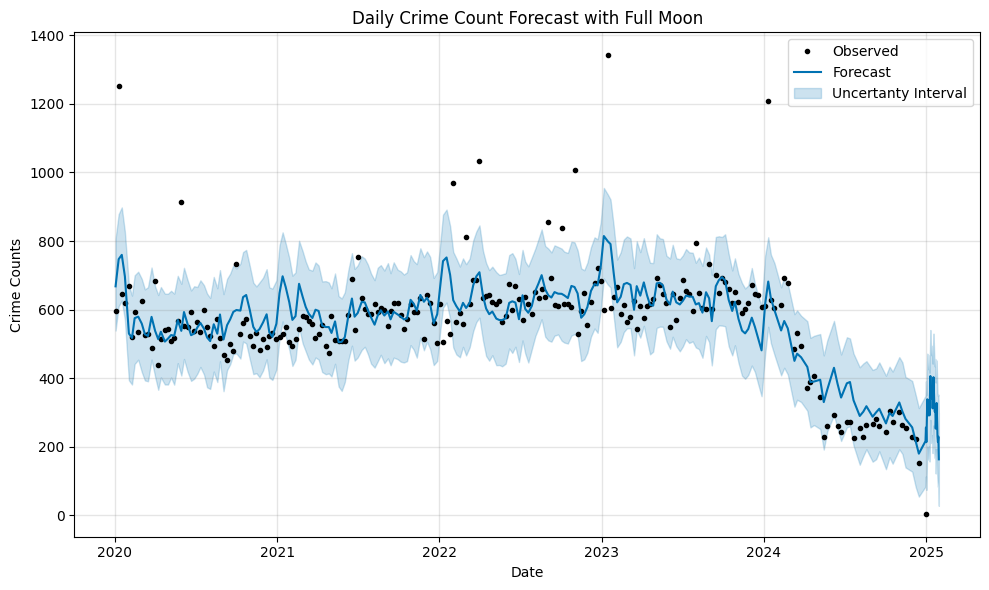

In [ ]:
# Use Prophet to look at the data
prophet_df = merged_df.reset_index()
prophet_df = prophet_df.rename(columns={'Date': 'ds'})

# Set Binary values
prophet_df['full_moon'] = (prophet_df['Moon Phase'] =='Full Moon').astype(int)

# Count Daily crimes:
daily_crime = prophet_df.groupby(['ds']).agg(
    crime_count=('Moon Phase', 'count'),
    full_moon=('full_moon', 'max')
).reset_index()

# Create & Fit the Prophet model 
model = Prophet()
model.add_regressor('full_moon')
model_data = daily_crime[['ds', 'crime_count', 'full_moon']]
model_data = model_data.rename(columns={'crime_count': 'y'})
model.fit(model_data)

# Make Predictions with Prophet
future = model.make_future_dataframe(periods=30)
future['full_moon'] = 0

forecast = model.predict(future)
fig = model.plot(forecast)

# Set Title and Lables for Plot output
ax = fig.gca()
ax.set_title('Daily Crime Count Forecast with Full Moon')
ax.set_xlabel('Date')
ax.set_ylabel('Crime Counts')
ax.legend(['Observed', 'Forecast', 'Uncertanty Interval'])

fig.tight_layout()
plt.show

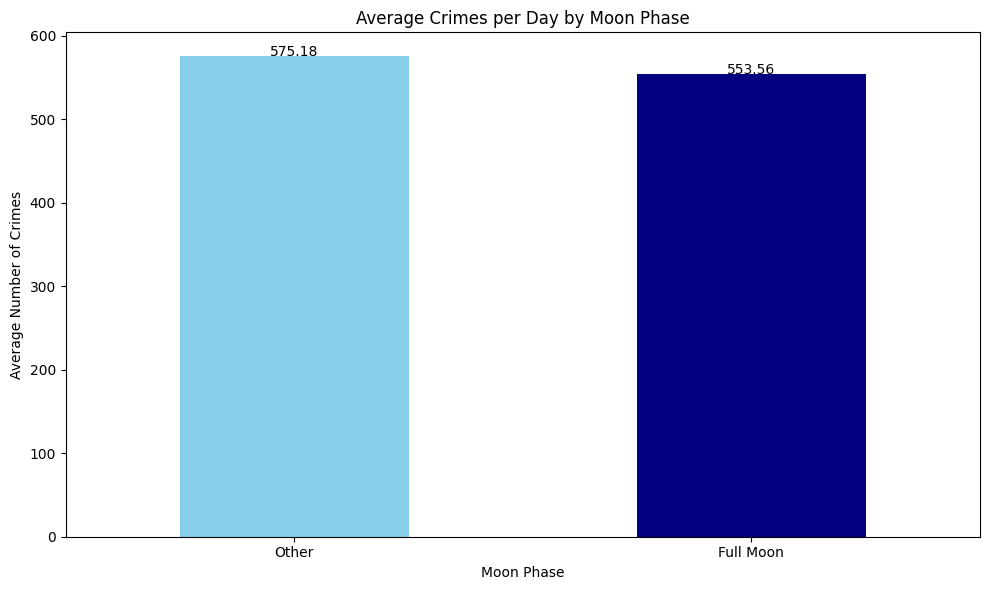

In [38]:
# Count Average number of crimes per day by Moon Phase
moon_days = merged_df.reset_index()[['Date', 'Moon Phase']].drop_duplicates()
days_count = moon_days['Moon Phase'].value_counts()
crime_count = merged_df['Moon Phase'].value_counts()

# Calculate crimes per day
crimes_per_day = crime_count / days_count

# Plot
plt.figure(figsize=(10, 6))
ax = crimes_per_day.plot(kind='bar', color=['skyblue', 'navy'], legend=False)
plt.title('Average Crimes per Day by Moon Phase')
plt.ylabel('Average Number of Crimes')
plt.xlabel('Moon Phase')
plt.xticks(rotation=0)

# Place values on top of bars
for i, v in enumerate(crimes_per_day):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

In [39]:
# First convert 'Occurred Date Time' to "datetime" & set as index
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.set_index('Date', inplace=True)

# Plot the Highest number of Offenses correlated to Full Moon Phase phases
    

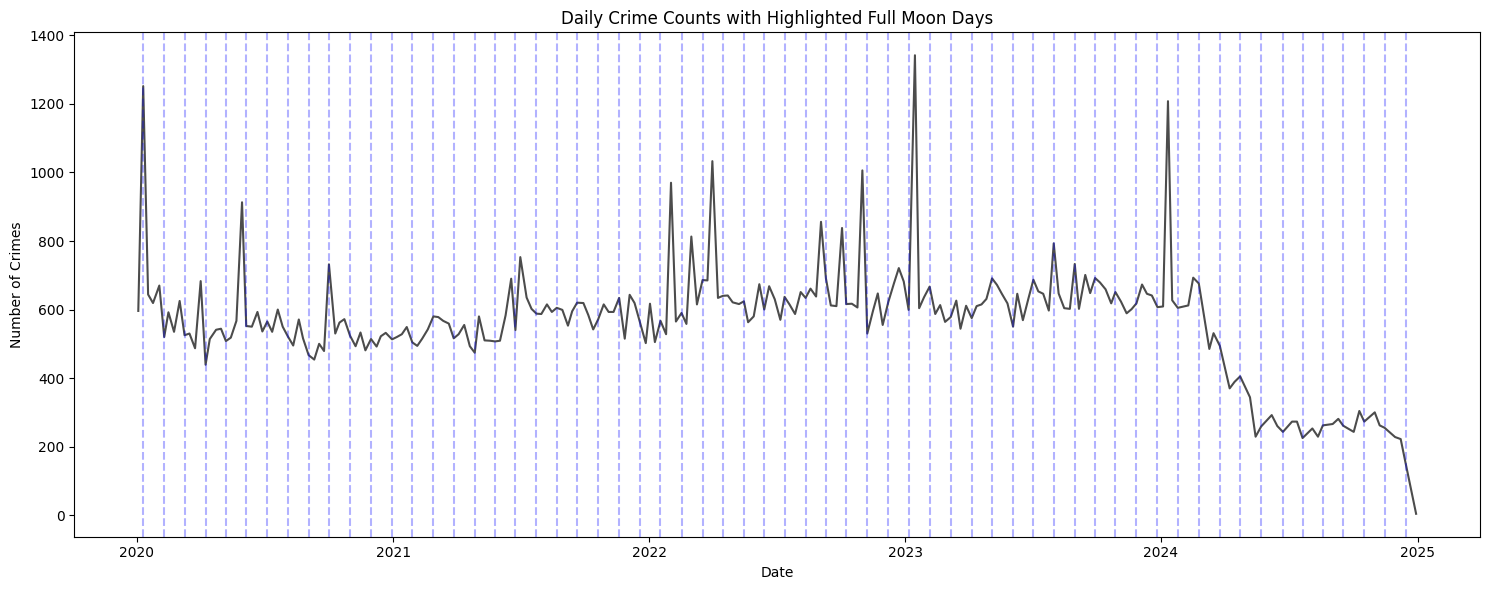

In [40]:
# Bring back in Time Series Plot and improve upon it:
# Plot the Highest number of Offenses correlated to Full Moon Phase phases
daily_crime_counts = merged_df.reset_index().groupby('Date').size().reset_index(name='crime_count')


# Get all Full Moon Dates:
full_moon_dates = merged_df[merged_df['Moon Phase'] == 'Full Moon'].reset_index()['Date'].unique()
# full_moon_crimes = daily_crime_counts[daily_crime_counts.index.isin(full_moon_dates)]
# other_days_crimes = daily_crime_counts[~daily_crime_counts.index.isin(full_moon_dates)]
# full_moon_average = full_moon_crimes.mean()
# other_days_average = other_days_crimes.mean()

# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(daily_crime_counts['Date'], daily_crime_counts['crime_count'], color='black', alpha=0.7)

# Highlight Full Moon Dates:
for date in full_moon_dates:
    plt.axvline(x=date, color='blue', alpha=0.3, linestyle='--')

plt.title("Daily Crime Counts with Highlighted Full Moon Days")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.tight_layout()
plt.show()

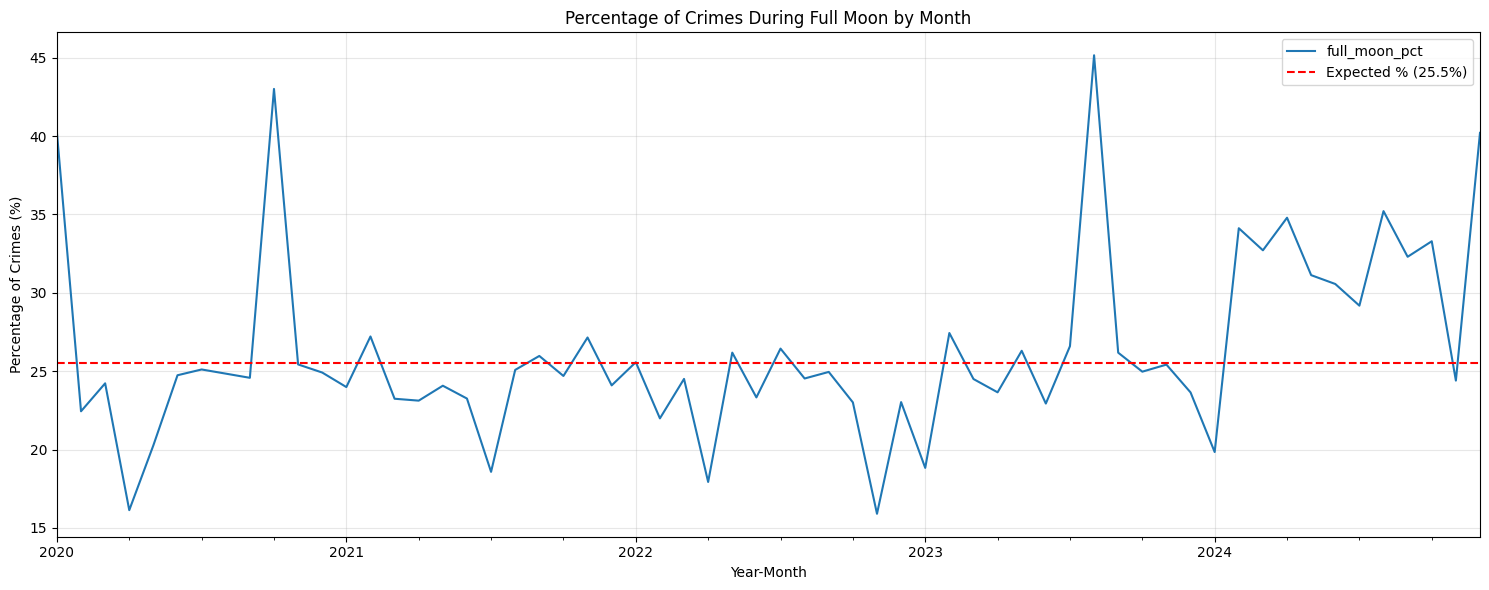

In [42]:
# Quick Test 2:
# Add year-month column
merged_df['year_month'] = merged_df.index.to_period('M')

# Group by year-month and moon phase
monthly_by_phase = merged_df.groupby([merged_df.index.to_period('M'), 'Moon Phase']).size().unstack(fill_value=0)


# Calculate number of days with Full vs. Other Moon Phases
full_moon_days = merged_df['Moon Phase'].value_counts().get('Full Moon', 0)
other_moon_days = merged_df['Moon Phase'].value_counts().sum() - full_moon_days

# Calculate the percentage of crimes during full moon for each month
if 'Full Moon' in monthly_by_phase.columns:
    monthly_by_phase['full_moon_pct'] = monthly_by_phase['Full Moon'] / monthly_by_phase.sum(axis=1) * 100

# Plot the percentage over time
plt.figure(figsize=(15, 6))
monthly_by_phase['full_moon_pct'].plot()
plt.axhline(y=full_moon_days/(full_moon_days+other_moon_days)*100, color='r', linestyle='--', 
            label=f'Expected % ({full_moon_days/(full_moon_days+other_moon_days)*100:.1f}%)')
plt.title('Percentage of Crimes During Full Moon by Month')
plt.ylabel('Percentage of Crimes (%)')
plt.xlabel('Year-Month')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()